## Setup

In [1]:
import os
from pathlib import Path
import random

In [2]:
# Path management
main_dir = str(Path(os.path.abspath('')).parents[1])
os.chdir(main_dir)
print('main dir:', main_dir)

main dir: /Users/pablo/OneDrive/data-science/github/aesuelogit


In [3]:
# Internal modules
from src.aesuelogit.models import UtilityParameters, BPRParameters, ODParameters, AESUELOGIT, NGD
from src.aesuelogit.networks import load_k_shortest_paths, build_tntp_network, Equilibrator, ColumnGenerator
from src.aesuelogit.etl import get_design_tensor, get_y_tensor, simulate_suelogit_data
from src.aesuelogit.experiments import *

In [4]:
# Seed for reproducibility
_SEED = 2022

np.random.seed(_SEED)
random.seed(_SEED)
tf.random.set_seed(_SEED)

## Experiments

In [5]:
list_experiments = ['convergence', 'multiday', 'noisy_counts', 'noisy_od', 'ill_scaled_od']

In [6]:
# run_experiment = dict.fromkeys(list_experiments,True)
run_experiment = dict.fromkeys(list_experiments, False)

# run_experiment['convergence'] = True
run_experiment['multiday'] = True
# run_experiment['noisy_counts'] = True
# run_experiment['noisy_od'] = True
# run_experiment['ill_scaled_od'] = True

## Build network

In [7]:
network_name = 'SiouxFalls'

tntp_network = build_tntp_network(network_name=network_name)

## Read OD matrix

In [8]:
Q = isl.reader.read_tntp_od(network_name=network_name)
tntp_network.load_OD(Q=Q)

Reading Q from external file
Matrix Q (24, 24) read in 0.5[s]                        

360600.0 trips were loaded among 528 o-d pairs


## Load paths

In [9]:
load_k_shortest_paths(network=tntp_network, k=2, update_incidence_matrices=True)

Generating at most 2 paths per od
1056 paths were generated among 528 od pairs in 0.5 [s]

1056 paths were loaded in the network
Matrix D (76, 1056) generated in 0.7[s]               

Matrix M (528, 1056) generated in 0.5[s]               

Matrix C (1056, 1056) generated in 0.0[s]               



## Read synthetic traffic data

In [10]:
df = pd.read_csv(
    main_dir + '/output/network-data/' + tntp_network.key + '/links/' + tntp_network.key + '-link-data.csv')

n_days = len(df.period.unique())
n_links = len(tntp_network.links)
n_hours = 1

features_Z = ['c', 's']

## Data processing

In [11]:
traveltime_data = get_design_tensor(y=df['traveltime'], n_links=n_links, n_days=n_days, n_hours=n_hours)
flow_data = get_y_tensor(y=df[['counts']], n_links=n_links, n_days=n_days, n_hours=n_hours)

Y = tf.concat([traveltime_data, flow_data], axis=3)
X = get_design_tensor(Z=df[['traveltime'] + features_Z], n_links=n_links, n_days=n_days, n_hours=n_hours)

2022-05-31 10:23:04.144026: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Network equilibrium predictions

In [12]:
equilibrator = Equilibrator(
    network=tntp_network,
    max_iters=100,
    method='fw',
    iters_fw=50,
    accuracy=1e-4,
)

## Learning parameters

In [13]:
_EPOCHS = 10
_BATCH_SIZE = 4
_LR = 5e-1  # Default is 1e-3. With 1e-1, training becomes unstable

## Utility Function

In [14]:
utility_parameters = UtilityParameters(features_Y=['tt'],
                                       features_Z=features_Z,
                                       true_values={'tt': -1, 'c': -6, 's': -3, 'psc_factor': 0, 'fixed_effect': 0},
                                       initial_values={'tt': 0, 'c': 0, 's': 0, 'psc_factor': 0,
                                                       'fixed_effect': np.zeros_like(tntp_network.links)},
                                       trainables={'psc_factor': False, 'fixed_effect': False},
                                       # trainables = None, #['features','psc_factor, fixed_effect']
                                       )

## Convergence Experiment

In [15]:
if run_experiment['convergence']:

    # optimizer = NGD(learning_rate=_LR)
    # optimizer = tf.keras.optimizers.Adagrad(learning_rate=_LR)
    optimizer = tf.keras.optimizers.Adam(learning_rate=_LR)

    bpr_parameters = BPRParameters(keys=['alpha', 'beta'],
                                   initial_values={'alpha': 0.15, 'beta': 1},
                                   # initial_values={'alpha': 0.05, 'beta': 2},
                                   true_values={'alpha': 0.15, 'beta': 4},
                                   trainables={'alpha': True, 'beta': True},
                                   # link_specifics = dict.fromkeys(['alpha','beta'],True)
                                   # trainables = ['alpha'],
                                   )

    od_parameters = ODParameters(key='od',
                                 periods=1,
                                 # initial_values = np.ones_like(tntp_network.q),
                                 # initial_values=0.6 * tntp_network.q.flatten(),
                                 initial_values=tntp_network.q.flatten(),
                                 true_values=tntp_network.q.flatten(),
                                 historic_values={1: tntp_network.q.flatten()},
                                 trainable=False)

    model = AESUELOGIT(
        key='model',
        network=tntp_network,
        equilibrator=equilibrator,
        utility=utility_parameters,
        bpr=bpr_parameters,
        od=od_parameters,
    )

    convergence_experiment = ConvergenceExperiment(
        seed=_SEED,
        name='Convergence Experiment',
        folderpath=isl.config.dirs['output_folder'] + 'experiments/' + network_name,
        model=model,
        optimizer=optimizer,
        X=X,
        Y=Y)

    convergence_experiment.run(epochs=_EPOCHS,
                               batch_size=_BATCH_SIZE,
                               loss_weights={'od': 0, 'theta': 0, 'tt': 1, 'flow': 1, 'bpr': 1},)

## Multiday experiment


Multiday Experiment

Replicate 1

Epoch: 0, n_train: 10, n_test: 118
0: train_loss=2.4e+07,  val_loss=2.4e+07, train_loss tt=93, val_loss tt=95, train_loss flow=2.4e+07, val_loss flow=2.4e+07, train_loss bpr=7.3, val_loss bpr=2, theta = [-1.9813 -6.0019 -3.7732], vot = 0.33, psc_factor = 0.0, avg abs theta fixed effect = 0, avg alpha = 0.15, avg beta = 4, avg abs diff demand =2.7e+02, time:  0.4

Epoch: 1, n_train: 10, n_test: 118
1: train_loss=1.5e+07,  val_loss=1.5e+07, train_loss tt=73, val_loss tt=72, train_loss flow=1.5e+07, val_loss flow=1.5e+07, train_loss bpr=7.3, val_loss bpr=2, theta = [-0.7927 -7.4574 -3.8634], vot = 0.11, psc_factor = 0.0, avg abs theta fixed effect = 0, avg alpha = 0.15, avg beta = 4, avg abs diff demand =2.2e+02, time:  0.5

Epoch: 2, n_train: 10, n_test: 118
2: train_loss=7.6e+06,  val_loss=7.4e+06, train_loss tt=52, val_loss tt=53, train_loss flow=7.6e+06, val_loss flow=7.4e+06, train_loss bpr=7.3, val_loss bpr=2, theta = [-1.4155 -7.5404 -2.8372], vot


SUE via fw (max iters: 100)

Equilibrium gaps: ['1E-03', '9E-05']
Initial Fisk Objective: -84,355,471.94
Final Fisk Objective: -83,836,830.21
Improvement Fisk Objective: 0.61%
Final gap: 9E-05. Acc. bound: 1E-04. Time: 0.5 [s]



Epoch: 0, n_train: 100, n_test: 28
0: train_loss=2.4e+07,  val_loss=2.4e+07, train_loss tt=94, val_loss tt=95, train_loss flow=2.4e+07, val_loss flow=2.4e+07, train_loss bpr=6.6, val_loss bpr=2, theta = [-1.9813 -6.0019 -3.7732], vot = 0.33, psc_factor = 0.0, avg abs theta fixed effect = 0, avg alpha = 0.15, avg beta = 4, avg abs diff demand =2.7e+02, time:  0.4

Epoch: 1, n_train: 100, n_test: 28
1: train_loss=1.4e+06,  val_loss=1.1e+06, train_loss tt=12, val_loss tt=11, train_loss flow=1.4e+06, val_loss flow=1.1e+06, train_loss bpr=6.6, val_loss bpr=2, theta = [ -2.138  -13.3598  -6.8221], vot = 0.16, psc_factor = 0.0, avg abs theta fixed effect = 0, avg alpha = 0.15, avg beta = 4, avg abs diff demand =1.1e+02, time:  1.9

Epoch: 2, n_train: 100, n_test: 28

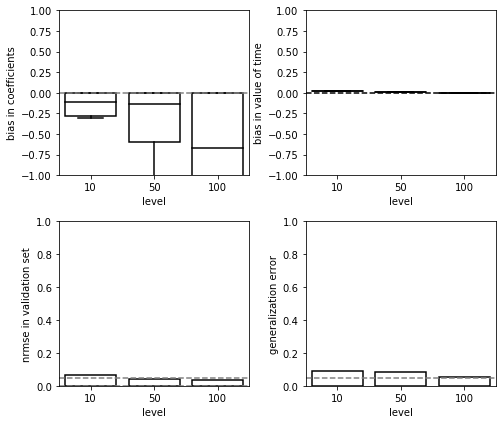

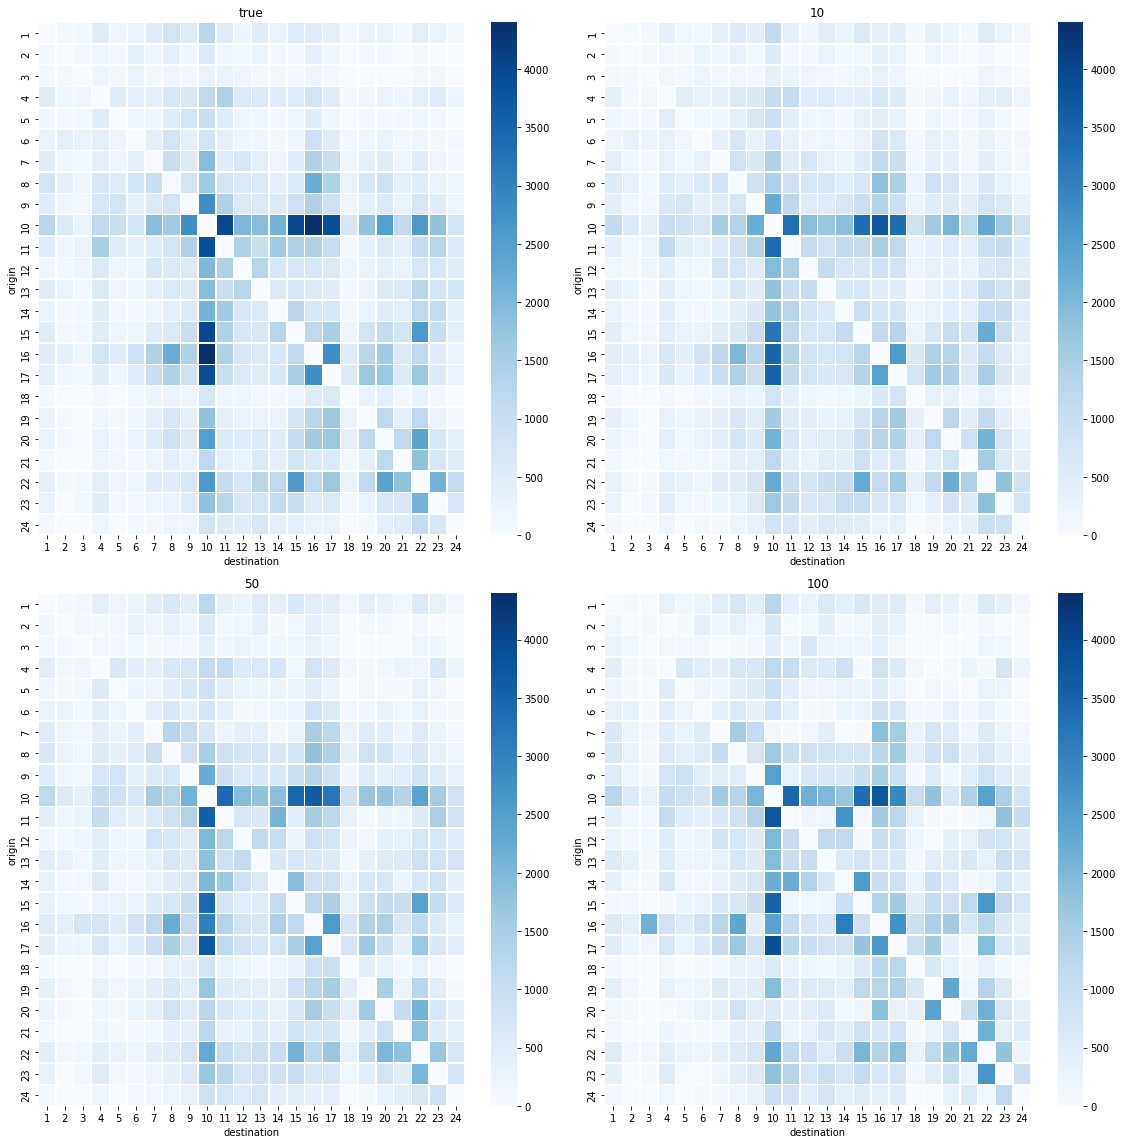


Replicate 2

Epoch: 0, n_train: 10, n_test: 118
0: train_loss=2.4e+07,  val_loss=2.4e+07, train_loss tt=95, val_loss tt=95, train_loss flow=2.4e+07, val_loss flow=2.4e+07, train_loss bpr=6.9, val_loss bpr=2, theta = [-1.9244 -5.0227 -2.1361], vot = 0.38, psc_factor = 0.0, avg abs theta fixed effect = 0, avg alpha = 0.15, avg beta = 4, avg abs diff demand =2.7e+02, time:  0.4

Epoch: 1, n_train: 10, n_test: 118
1: train_loss=7.5e+06,  val_loss=7.3e+06, train_loss tt=60, val_loss tt=59, train_loss flow=7.5e+06, val_loss flow=7.3e+06, train_loss bpr=6.9, val_loss bpr=2, theta = [-0.6574 -4.0727 -0.3737], vot = 0.16, psc_factor = 0.0, avg abs theta fixed effect = 0, avg alpha = 0.15, avg beta = 4, avg abs diff demand =1.6e+02, time:  0.6

Epoch: 2, n_train: 10, n_test: 118
2: train_loss=5.8e+06,  val_loss=5.4e+06, train_loss tt=75, val_loss tt=78, train_loss flow=5.8e+06, val_loss flow=5.4e+06, train_loss bpr=6.9, val_loss bpr=2, theta = [-1.8918 -3.9496 -0.5803], vot = 0.48, psc_factor =


SUE via fw (max iters: 100)

Equilibrium gaps: ['7E-03', '6E-04', '3E-04', '5E-04', '3E-04', '3E-05']
Initial Fisk Objective: -514,714,000.9
Final Fisk Objective: -504,773,172.96
Improvement Fisk Objective: 1.93%
Final gap: 3E-05. Acc. bound: 1E-04. Time: 1.6 [s]



Epoch: 0, n_train: 100, n_test: 28
0: train_loss=2.4e+07,  val_loss=2.3e+07, train_loss tt=95, val_loss tt=94, train_loss flow=2.4e+07, val_loss flow=2.3e+07, train_loss bpr=6.8, val_loss bpr=1.9, theta = [-1.9244 -5.0227 -2.1361], vot = 0.38, psc_factor = 0.0, avg abs theta fixed effect = 0, avg alpha = 0.15, avg beta = 4, avg abs diff demand =2.7e+02, time:  0.7

Epoch: 1, n_train: 100, n_test: 28
1: train_loss=2.4e+06,  val_loss=2.1e+06, train_loss tt=48, val_loss tt=47, train_loss flow=2.4e+06, val_loss flow=2.1e+06, train_loss bpr=6.8, val_loss bpr=1.9, theta = [ -7.945  -16.8259  -7.7791], vot = 0.47, psc_factor = 0.0, avg abs theta fixed effect = 0, avg alpha = 0.15, avg beta = 4, avg abs diff demand =1.7e+02, time:

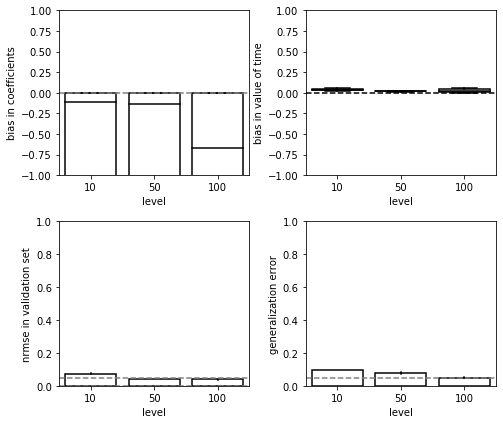

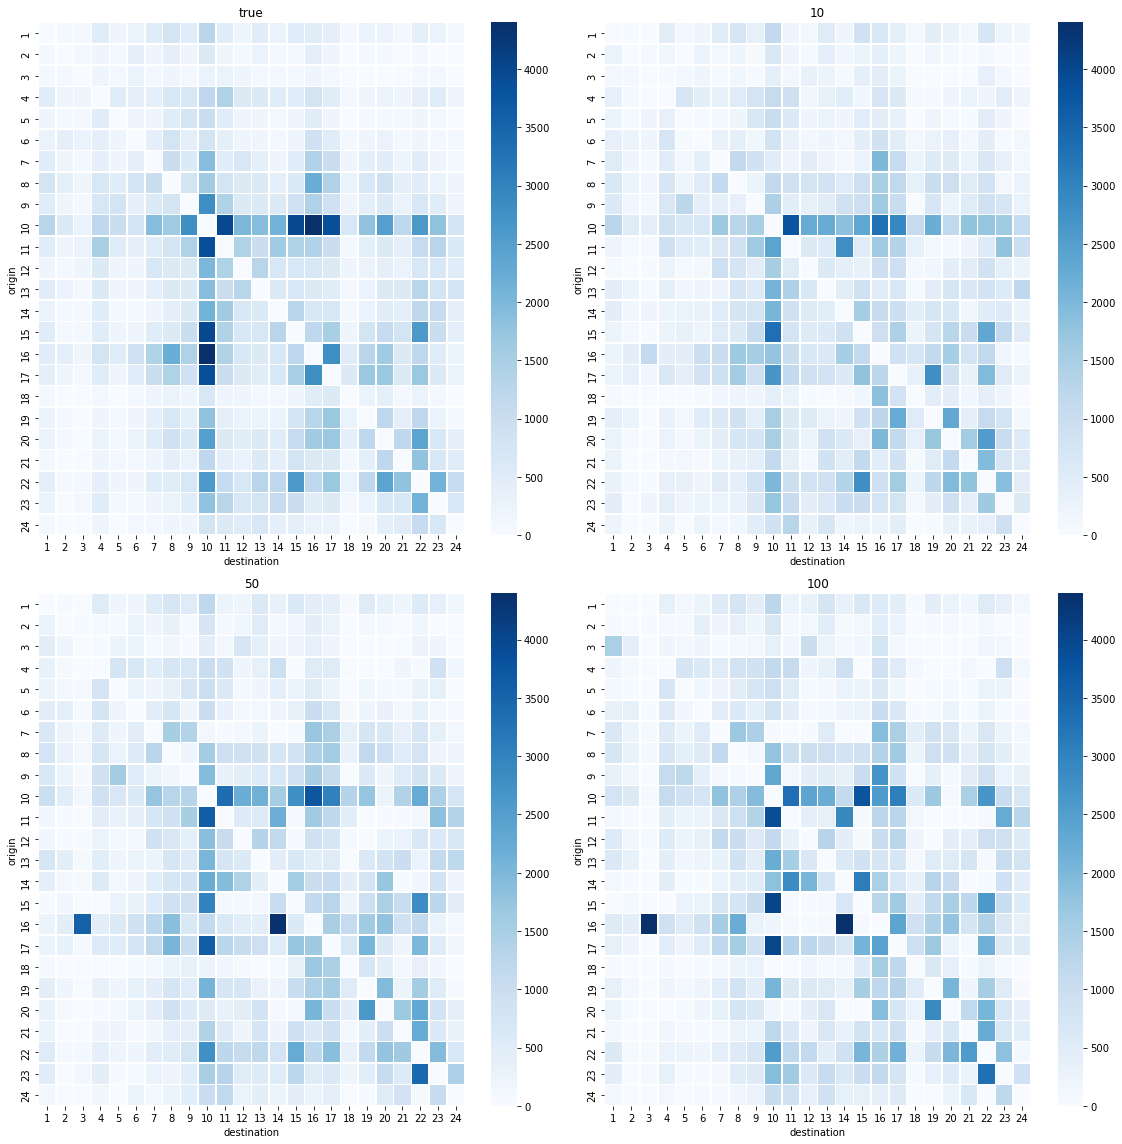


Replicate 3

Epoch: 0, n_train: 10, n_test: 118
0: train_loss=2.5e+07,  val_loss=2.4e+07, train_loss tt=93, val_loss tt=93, train_loss flow=2.5e+07, val_loss flow=2.4e+07, train_loss bpr=7.5, val_loss bpr=2, theta = [-0.8249 -5.7775 -3.2274], vot = 0.14, psc_factor = 0.0, avg abs theta fixed effect = 0, avg alpha = 0.15, avg beta = 4, avg abs diff demand =2.7e+02, time:  0.5

Epoch: 1, n_train: 10, n_test: 118
1: train_loss=6e+06,  val_loss=6.1e+06, train_loss tt=94, val_loss tt=1.1e+02, train_loss flow=6e+06, val_loss flow=6.1e+06, train_loss bpr=7.5, val_loss bpr=2, theta = [-3.7207 -2.792   0.0899], vot = 1.33, psc_factor = 0.0, avg abs theta fixed effect = 0, avg alpha = 0.15, avg beta = 4, avg abs diff demand =1.2e+02, time:  0.8

Epoch: 2, n_train: 10, n_test: 118
2: train_loss=1e+07,  val_loss=1.1e+07, train_loss tt=4.8e+02, val_loss tt=6.4e+02, train_loss flow=1e+07, val_loss flow=1.1e+07, train_loss bpr=7.5, val_loss bpr=2, theta = [-5.0238 -3.0247 -2.5353], vot = 1.66, psc_f


SUE via fw (max iters: 100)

Equilibrium gaps: ['4E-05']
Initial Fisk Objective: -306,905,562.49
Final Fisk Objective: -305,801,638.76
Improvement Fisk Objective: 0.36%
Final gap: 4E-05. Acc. bound: 1E-04. Time: 0.7 [s]



Epoch: 0, n_train: 100, n_test: 28
0: train_loss=2.4e+07,  val_loss=2.4e+07, train_loss tt=93, val_loss tt=93, train_loss flow=2.4e+07, val_loss flow=2.4e+07, train_loss bpr=6.7, val_loss bpr=1.9, theta = [-0.8249 -5.7775 -3.2274], vot = 0.14, psc_factor = 0.0, avg abs theta fixed effect = 0, avg alpha = 0.15, avg beta = 4, avg abs diff demand =2.7e+02, time:  0.8

Epoch: 1, n_train: 100, n_test: 28
1: train_loss=2e+06,  val_loss=1.6e+06, train_loss tt=39, val_loss tt=36, train_loss flow=2e+06, val_loss flow=1.6e+06, train_loss bpr=6.7, val_loss bpr=1.9, theta = [-10.7834 -22.4794 -14.5802], vot = 0.48, psc_factor = 0.0, avg abs theta fixed effect = 0, avg alpha = 0.15, avg beta = 4, avg abs diff demand =2.2e+02, time:  3.5

Epoch: 2, n_train: 100, n_test: 28
2: tra

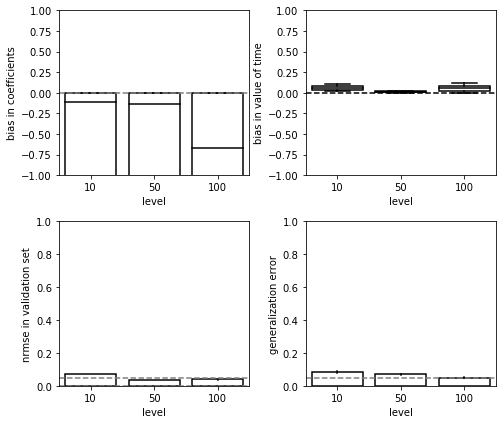

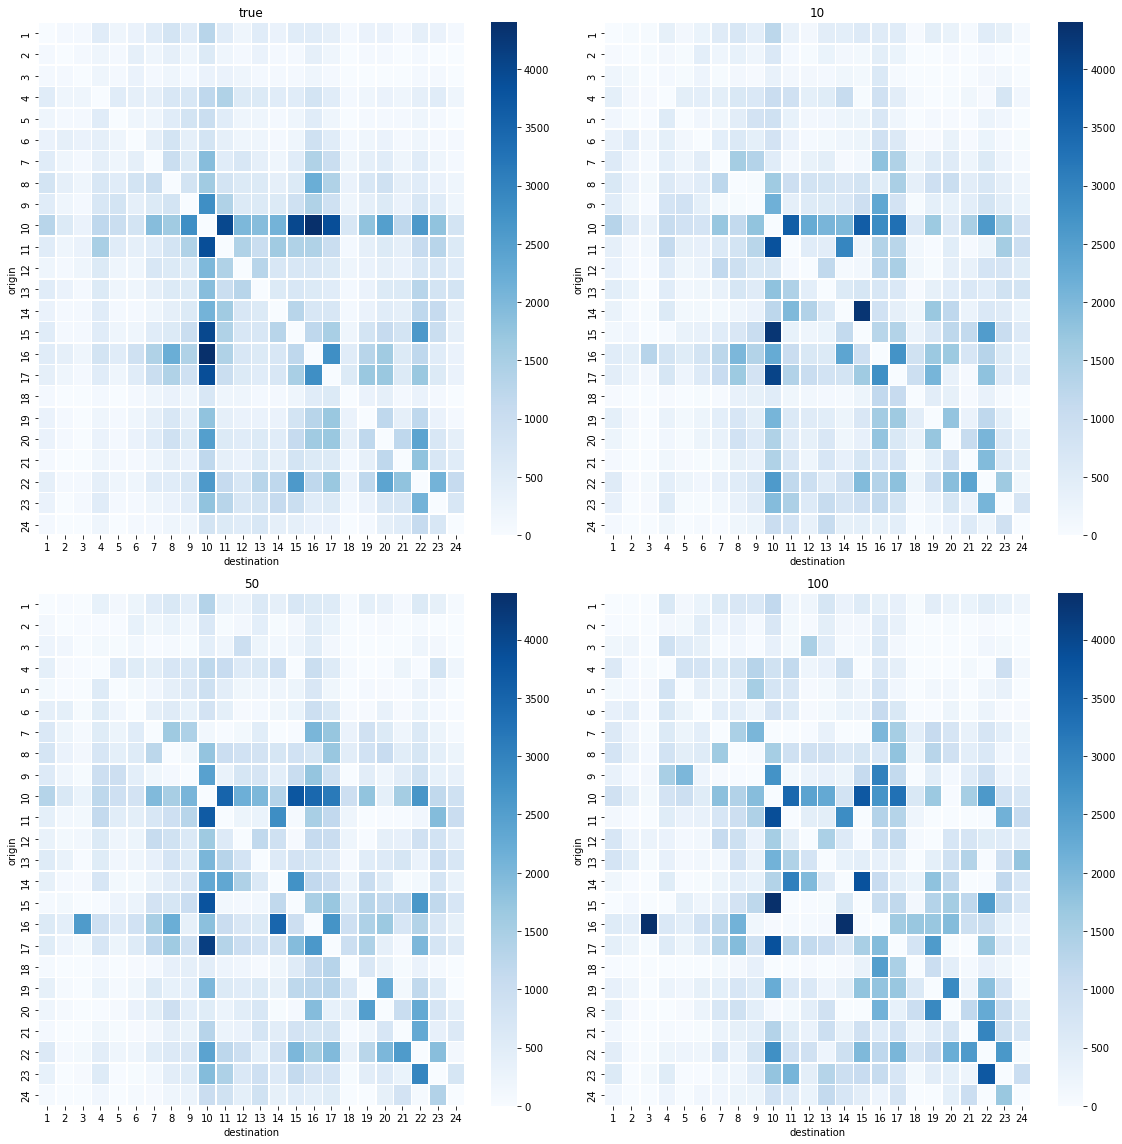


Replicate 4

Epoch: 0, n_train: 10, n_test: 118
0: train_loss=2.4e+07,  val_loss=2.4e+07, train_loss tt=94, val_loss tt=95, train_loss flow=2.4e+07, val_loss flow=2.4e+07, train_loss bpr=6.2, val_loss bpr=2, theta = [-1.9494 -5.347  -3.2942], vot = 0.36, psc_factor = 0.0, avg abs theta fixed effect = 0, avg alpha = 0.15, avg beta = 4, avg abs diff demand =2.7e+02, time:  0.5

Epoch: 1, n_train: 10, n_test: 118
1: train_loss=5.1e+06,  val_loss=4.7e+06, train_loss tt=82, val_loss tt=86, train_loss flow=5.1e+06, val_loss flow=4.7e+06, train_loss bpr=6.2, val_loss bpr=2, theta = [-2.9779 -4.5077 -3.0748], vot = 0.66, psc_factor = 0.0, avg abs theta fixed effect = 0, avg alpha = 0.15, avg beta = 4, avg abs diff demand =1.1e+02, time:  0.8

Epoch: 2, n_train: 10, n_test: 118
2: train_loss=9.9e+06,  val_loss=9.9e+06, train_loss tt=4e+02, val_loss tt=4.5e+02, train_loss flow=9.9e+06, val_loss flow=9.9e+06, train_loss bpr=6.2, val_loss bpr=2, theta = [-4.2817 -6.0651 -8.4256], vot = 0.71, psc_


SUE via fw (max iters: 100)

Equilibrium gaps: ['9E-03', '2E-04', '8E-05']
Initial Fisk Objective: -330,673,343.18
Final Fisk Objective: -323,023,233.84
Improvement Fisk Objective: 2.31%
Final gap: 8E-05. Acc. bound: 1E-04. Time: 0.9 [s]



Epoch: 0, n_train: 100, n_test: 28
0: train_loss=2.4e+07,  val_loss=2.4e+07, train_loss tt=94, val_loss tt=95, train_loss flow=2.4e+07, val_loss flow=2.4e+07, train_loss bpr=6.7, val_loss bpr=2.1, theta = [-1.9494 -5.347  -3.2942], vot = 0.36, psc_factor = 0.0, avg abs theta fixed effect = 0, avg alpha = 0.15, avg beta = 4, avg abs diff demand =2.7e+02, time:  0.6

Epoch: 1, n_train: 100, n_test: 28
1: train_loss=1.3e+06,  val_loss=1.2e+06, train_loss tt=14, val_loss tt=18, train_loss flow=1.3e+06, val_loss flow=1.2e+06, train_loss bpr=6.7, val_loss bpr=2.1, theta = [ -6.1008 -22.7035 -13.7577], vot = 0.27, psc_factor = 0.0, avg abs theta fixed effect = 0, avg alpha = 0.15, avg beta = 4, avg abs diff demand =1.8e+02, time:  2.6

Epoch: 2, n_train: 

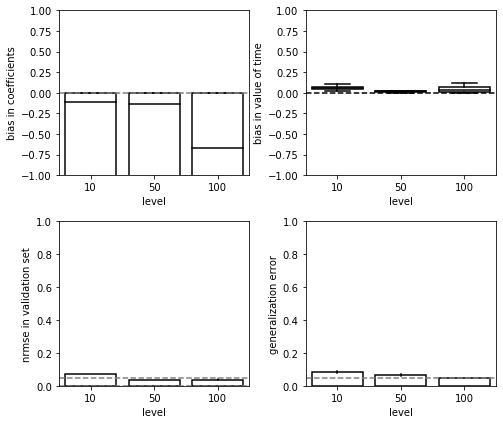

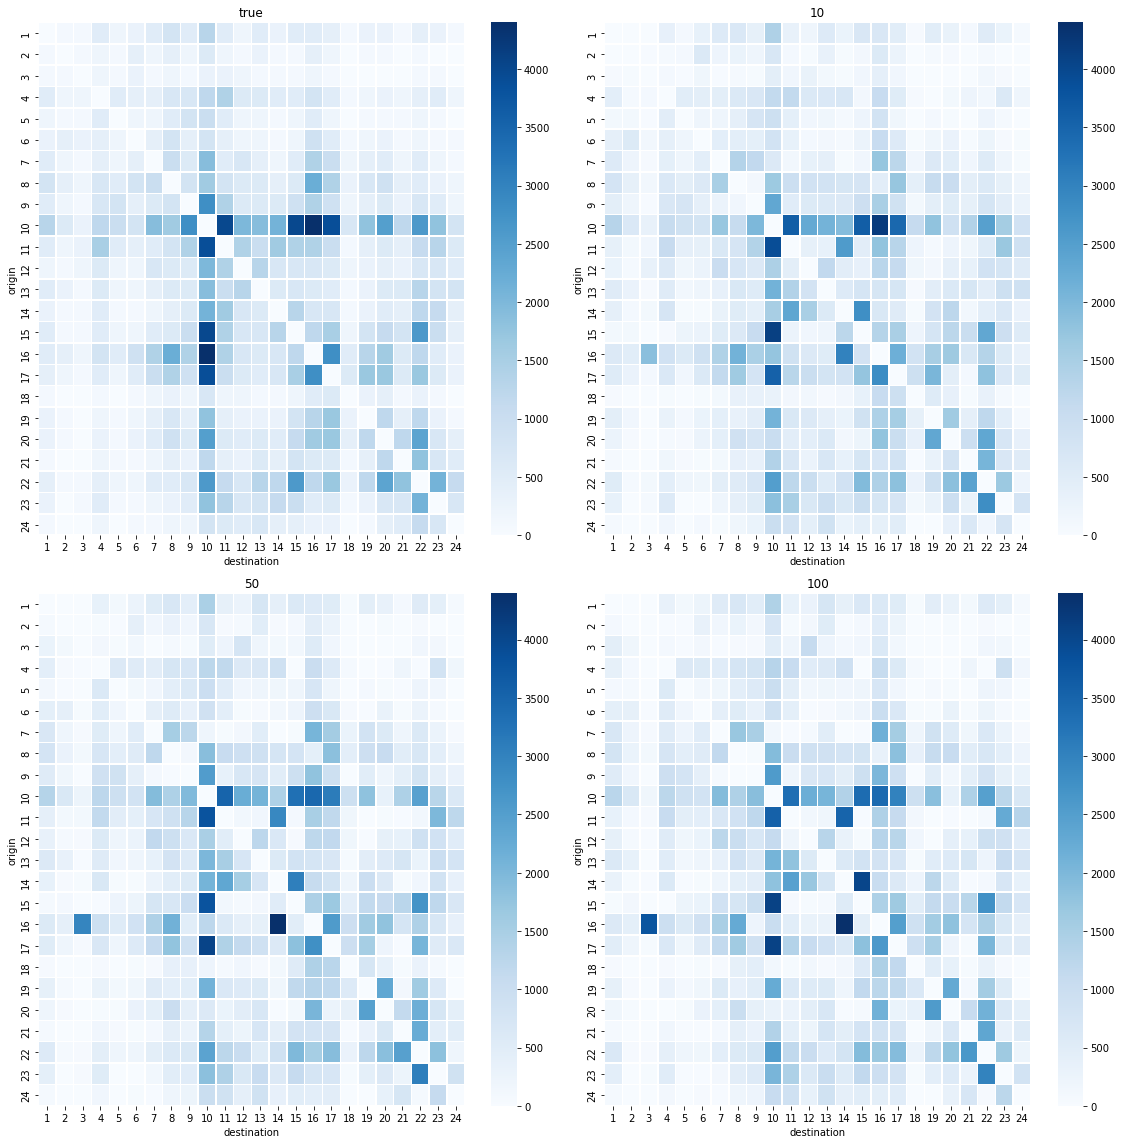


Replicate 5

Epoch: 0, n_train: 10, n_test: 118
0: train_loss=2.4e+07,  val_loss=2.3e+07, train_loss tt=95, val_loss tt=95, train_loss flow=2.4e+07, val_loss flow=2.3e+07, train_loss bpr=5.7, val_loss bpr=2, theta = [-1.3205 -6.5697 -2.2279], vot = 0.20, psc_factor = 0.0, avg abs theta fixed effect = 0, avg alpha = 0.15, avg beta = 4, avg abs diff demand =2.7e+02, time:  0.5

Epoch: 1, n_train: 10, n_test: 118
1: train_loss=3.9e+06,  val_loss=3.7e+06, train_loss tt=40, val_loss tt=41, train_loss flow=3.9e+06, val_loss flow=3.7e+06, train_loss bpr=5.7, val_loss bpr=2, theta = [ -2.5968 -11.3075  -6.4381], vot = 0.23, psc_factor = 0.0, avg abs theta fixed effect = 0, avg alpha = 0.15, avg beta = 4, avg abs diff demand =1.3e+02, time:  0.7

Epoch: 2, n_train: 10, n_test: 118
2: train_loss=8.7e+06,  val_loss=8.8e+06, train_loss tt=1.9e+02, val_loss tt=2e+02, train_loss flow=8.7e+06, val_loss flow=8.8e+06, train_loss bpr=5.7, val_loss bpr=2, theta = [ -5.6304 -17.6462 -10.1968], vot = 0.32


SUE via fw (max iters: 100)

Equilibrium gaps: ['1E-02', '2E-04', '3E-04', '4E-05']
Initial Fisk Objective: -679,098,075.66
Final Fisk Objective: -668,475,469.84
Improvement Fisk Objective: 1.56%
Final gap: 4E-05. Acc. bound: 1E-04. Time: 1.3 [s]



Epoch: 0, n_train: 100, n_test: 28
0: train_loss=2.4e+07,  val_loss=2.4e+07, train_loss tt=95, val_loss tt=94, train_loss flow=2.4e+07, val_loss flow=2.4e+07, train_loss bpr=6.7, val_loss bpr=1.9, theta = [-1.3205 -6.5697 -2.2279], vot = 0.20, psc_factor = 0.0, avg abs theta fixed effect = 0, avg alpha = 0.15, avg beta = 4, avg abs diff demand =2.7e+02, time:  0.8


KeyboardInterrupt: 

In [16]:
if run_experiment['multiday']:

    optimizer = tf.keras.optimizers.Adam(learning_rate=_LR)

    bpr_parameters = BPRParameters(keys=['alpha', 'beta'],
                                   # initial_values={'alpha': 0.1, 'beta': 1},
                                   initial_values={'alpha': 0.15, 'beta': 4},
                                   true_values={'alpha': 0.15, 'beta': 4},
                                   trainables=dict.fromkeys(['alpha', 'beta'], False),
                                   )

    od_parameters = ODParameters(key='od',
                                 periods=1,
                                 # initial_values=100*np.ones_like(tntp_network.q).flatten(),
                                 initial_values=0.6*tntp_network.q.flatten(),
                                 # initial_values=tntp_network.q.flatten(),
                                 true_values=tntp_network.q.flatten(),
                                 historic_values={1: tntp_network.q.flatten()},
                                 trainable=True)

    model = AESUELOGIT(
        key='model',
        network=tntp_network,
        equilibrator=equilibrator,
        utility=utility_parameters,
        bpr=bpr_parameters,
        od=od_parameters,
    )

    multiday_experiment = MultidayExperiment(
        seed=_SEED,
        name='Multiday Experiment',
        folderpath=isl.config.dirs['output_folder'] + 'experiments/' + network_name,
        model=model,
        optimizer=optimizer,
        noise = {'tt': 0, 'flow': 0.05},
        X=X,
        Y=Y)

    multiday_experiment.run(epochs=_EPOCHS,
                            replicates = 10,
                            range_initial_values= (-1,1),
                            batch_size=_BATCH_SIZE,
                            levels = [10,50,100],
                            loss_weights={'od': 0, 'theta': 0, 'tt': 1, 'flow': 1, 'bpr': 0},
                            )